## Black-Scholes with Devito

Black-Scholes is a model used to determine the theoretical value of a call or a put option in finance. A way that traders might use it is to buy an option priced under the Black-Scholes value and sell options priced higher than the calculated value. Larger firms might use the model to hedge, or attempt to eliminate risk, by buying and selling the underlying asset in just the right way. Here we solve the partial differential equation and calculate theoretical "fair" values for an option from one year to expiration to the expiration date.

Symbol definitions:

* $S(t)$ is the price of the underlying asset at time $t$
* $V(t,S)$ is the value of the option at time $t$ and stock price $S$
* $K$ is the strike price of the option
* $r$ is the annualized risk-free interest rate
* $\sigma$ is the standard deviation of the stock's returns
* $t$ is the time, in years, to expiration.

In [1]:
from devito import (Eq, Grid, TimeFunction, Operator, solve, Constant, 
                    SpaceDimension, configuration, centered)

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.axis3d import Axis
import matplotlib.pyplot as plt
import matplotlib as mpl

from sympy.stats import Normal, cdf
import numpy as np
import time as timer

%matplotlib inline
mpl.rc('font', size=14)

configuration["log-level"] = 'INFO'

## Constants
# The strike price of the option
K = 100.0

# The annualized risk free interest rate
r = 0.12

# The standard deviation of the stock's returns
sigma = 0.1

# The S (price of the asset) range to process
smin = 70
smax = 130

# If you want to try some different problems, uncomment these lines

## Example 2
# K = 10.0
# r = 0.1
# sigma = 0.2
# smin = 0.0
# smax = 20.0

## Example 3
# K = 100.0
# r = 0.05
# sigma = 0.25
# smin = 50.0
# smax = 150.0

# Amount of padding to proccess left/right (hidden from graphs)
padding = 10
smin -= padding
smax += padding

# Extent calculations
tmax = 1.0
dt0 = 0.0005
ds0  = 1.0
nt = (int)(tmax / dt0) + 1
ns = int((smax - smin) / ds0) + 1 

shape = (ns, )
origin =(smin, )
spacing = (ds0, )
extent = int(ds0 * (ns - 1))

print(f"dt, tmax, nt: {dt0}, {tmax}, {nt}")
print(f"shape: {shape}")
print(f"origin: {origin}")
print(f"spacing: {spacing}")
print(f"extent: {extent}")

dt, tmax, nt: 0.0005, 1.0, 2001
shape: (81,)
origin: (60,)
spacing: (1.0,)
extent: 80


## Black Scholes initial boundary value problem
$$
- \frac{\partial}{\partial t} V(t,s) + r\ s\ \frac{\partial}{\partial s} V(t,s) + \frac{1}{2}\ 
    \sigma^2\ s^2\ \frac{\partial^2}{\partial s^2} V(t,s) - r\ V(t,s) = 0
$$

This differs from the regular Black Scholes PDE since our $\frac{\partial}{\partial t} V(t,s)$ is negative. This is because instead of using a terminal condition, we are using an initial condition and solving backward in time.

#### Update equation

In our update equation, we solve for $v.\text{forward} = v{\left(t + dt,s \right)}$.

Because $$-\frac{\partial}{\partial t} V(t,s) = \displaystyle \frac{v{\left(t,s \right)}}{dt} - \frac{v{\left(t + dt,s \right)}}{dt}$$

Our update equation will be:

$$v{\left(t + dt,s \right)} = v{\left(t,s \right)} + dt \left( r\ s\ \frac{\partial}{\partial s} V(t,s) + \frac{1}{2}\ \sigma^2\ s^2\ \frac{\partial^2}{\partial s^2} V(t,s) - r\ V(t,s) \right)$$

We give this to Devito to solve for the next timestep of the problem. Our finite difference order of accuracy will be 4, meaning we will use two points off center to approximate the derivatives.

#### Initial and boundary conditions

The boundary conditions are the following:

Call option:

* For very large S: $V\left(t,S\right) \approx S$
* For very small S: $V\left(t,S\right) \approx 0$

Put option:

* For very large S: $V\left(t,S\right) \approx 0$
* For very small S: $V\left(t,S\right) \approx K e^{-r(T-t)}$

In this example we are solving for a call option. Because we have a set S range we are solving the problem in (smin to smax), we don't need to worry about either of these boundary conditions. The initial condition will be:

$$V(t=T,S)=\max(S-K,0)$$

Where T is the time at expiration. For us this is flipped, so we set this condition at $T = 0$.

When solving this problem, most approaches typically convert to the heat equation with a variable change of $x=\ln S$, which gives a simpler PDE which is computationaly easier to solve. However, with the power of Devito, we can just solve the Black Scholes PDE directly.

In [2]:
s = SpaceDimension(name='s', spacing=Constant(name='h_s', value=spacing[0]))
grid = Grid(shape=shape, origin=origin, extent=extent, dimensions=(s, ))

so = 2
v        = TimeFunction(name='v',        grid=grid, space_order=so, time_order=1, save=nt)
v_no_bc  = TimeFunction(name='v_no_bc',  grid=grid, space_order=so, time_order=1, save=nt)

t,s = v.dimensions
ds = s.spacing
dt = t.spacing

# Derivatives
vds = v.ds(side=centered)
vds2 = v.ds2

# Centered der eq
pde_centered = -v.dt + r*(smin+ds0*s) * vds + 0.5 * sigma**2 * (smin+ds0*s)**2 * vds2 - r*v

# Time update equations
update_centered = solve(pde_centered, v.forward)

## Boundary conditions

Because this problem has non zero boundary conditions, we need to add a boundary condition on the right so that when the equation refers to out of bounds values it has a good approximation. Because the slope on the right is linear, a Neumann boundary condition is a good choice. Because our order of accuracy is 4, we need to implement the condition for two points past the right edge.

ASCII representation of what happens at the boundary:

                          |  o  v(t,smax+1)  
                          | /
                          |/
                          o  v(t,smax)  
                         /|
                        / |
          v(t,smax-1)  X  |
                      /   | BC: constant slope for v when s >= smax
                     /    | need 2 points for a 4th order derivative
       v(t,smax-2)  X     |
                   /      |   slope = v(t,smax-1) - v(t,smax-2)
                  /       |   v(t,smax)   = v(t,smax-1) + slope
    v(t,smax-2)  X        |   v(t,smax+1) = v(t,smax)   + slope
                          |
         interior         |        boundary 
        (s < smax)      smax      (s >= smax)

In [3]:
# Equations with Neumann boundary conditions
eq       = [Eq(v[t,extent], v[t,extent-1]+(v[t,extent-1]-v[t,extent-2])),
            Eq(v[t,extent+1], v[t,extent]+(v[t,extent-1]-v[t,extent-2])),
            Eq(v.forward, update_centered)]
eq_no_bc = [Eq(v.forward, update_centered)]

op       = Operator(eq, subs=v.grid.spacing_map)
op_no_bc = Operator(eq_no_bc, subs=v_no_bc.grid.spacing_map)

# Initial conditions

for i in range(shape[0]):
    v.data[0, i]       = max((smin + ds0 * i) - K, 0)
    v_no_bc.data[0, i] = max((smin + ds0 * i) - K, 0)

In [4]:
#NBVAL_IGNORE_OUTPUT

# Run our operators
startDevito = timer.time()

# Apply operator
op.apply(dt=dt0)

endDevito = timer.time()

# Apply operator without boundary condition
op_no_bc.apply(dt=dt0, v=v_no_bc)

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.00023999999999999944, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

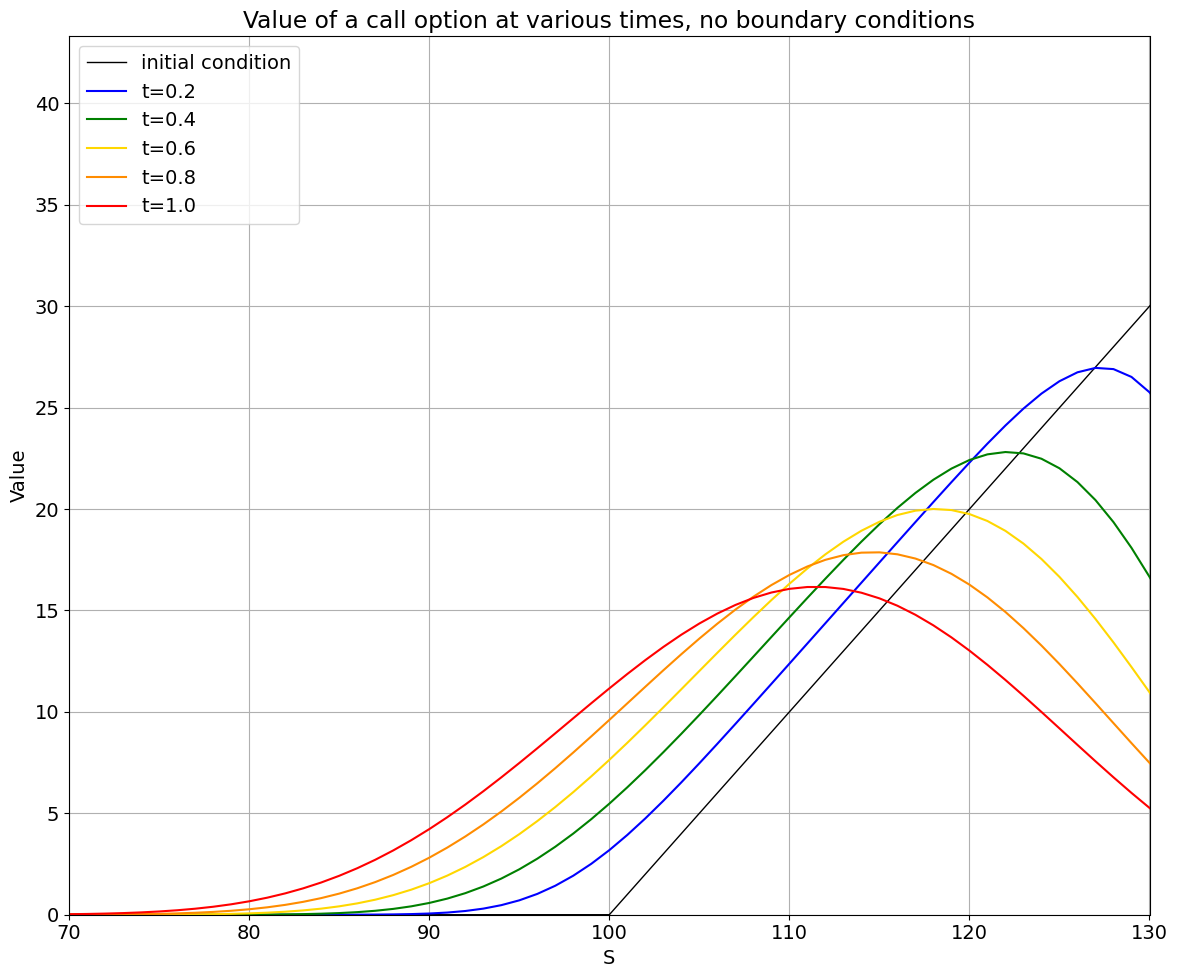

In [5]:
#NBVAL_IGNORE_OUTPUT

# Get an appropriate ylimit
slice_smax = v.data[:, int(smax-smin-padding)]
ymax = max(slice_smax) + 2

# Plot
s = np.linspace(smin, smax, shape[0])
plt.figure(figsize=(12,10), facecolor='w')

time = [1*nt//5, 2*nt//5, 3*nt//5, 4*nt//5, 5*nt//5-1]
colors = ["blue", "green", "gold", "darkorange", "red"]

# initial conditions
plt.plot(s, v_no_bc.data[0,:], '-', color="black", label='initial condition', linewidth=1)

for i in range(len(time)):
    plt.plot(s, v_no_bc.data[time[i],:], '-', color=colors[i], label='t='+str(time[i]*dt0), linewidth=1.5)

plt.xlim([smin+padding,smax-padding])
plt.ylim([0,ymax])

plt.legend(loc=2)
plt.grid(True)
plt.xlabel("S")
plt.ylabel("Value")
plt.title("Value of a call option at various times, no boundary conditions")
plt.tight_layout()

Here is what our plot looks like without boundary conditions. Because on the right side the derivatives try to read data that is not defined, the lines for the value of our option fall incorrectly towards zero. 

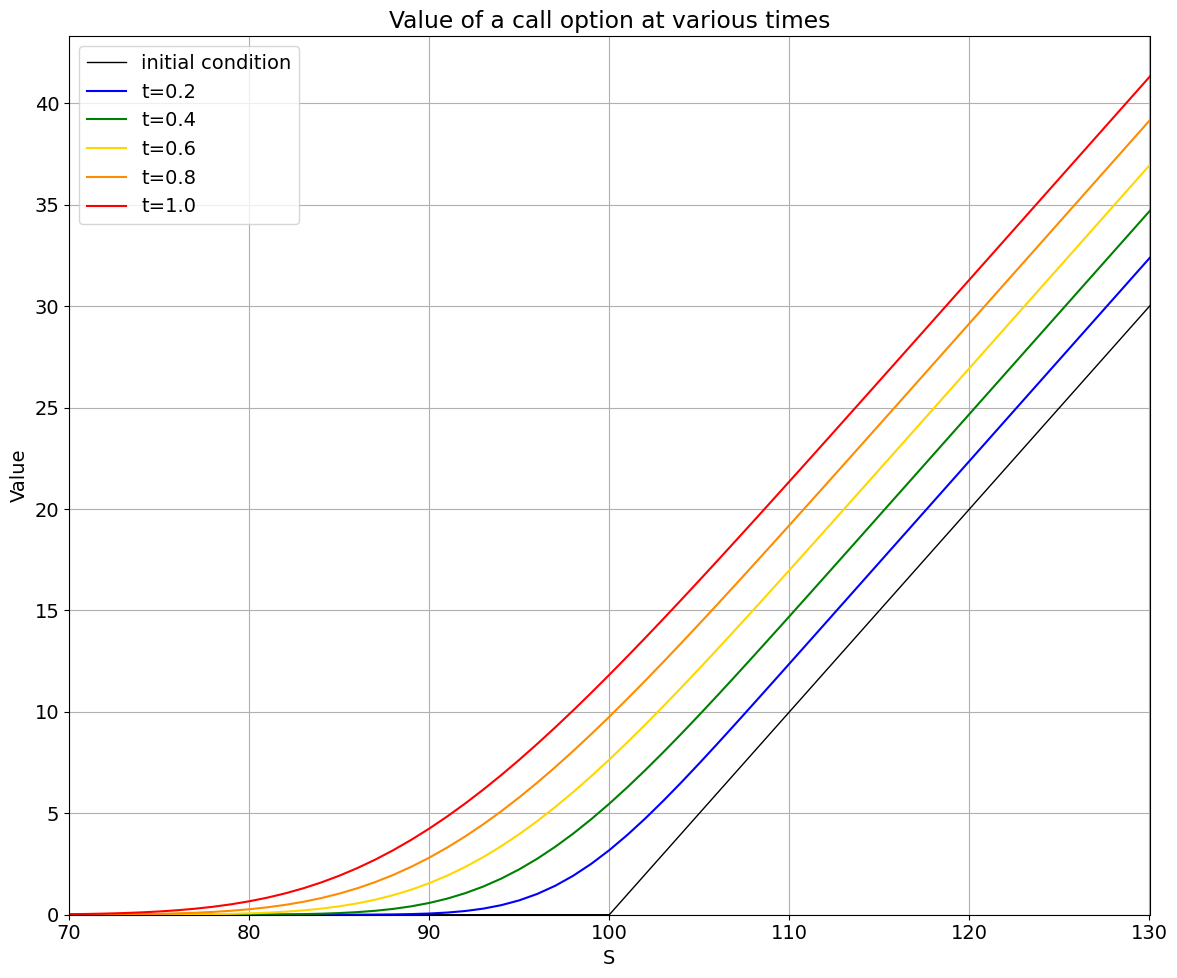

In [6]:
#NBVAL_IGNORE_OUTPUT

# Get an appropriate ylimit
slice_smax = v.data[:,int(smax-smin-padding)]
ymax = max(slice_smax) + 2

# Plot
s = np.linspace(smin, smax, shape[0])
plt.figure(figsize=(12,10), facecolor='w')

time = [1*nt//5, 2*nt//5, 3*nt//5, 4*nt//5, 5*nt//5-1]
colors = ["blue", "green", "gold", "darkorange", "red"]

# initial conditions
plt.plot(s, v.data[0,:], '-', color="black", label='initial condition', linewidth=1)

for i in range(len(time)):
    plt.plot(s, v.data[time[i],:], '-', color=colors[i], label=f't={time[i]*dt0}', linewidth=1.5)

plt.xlim([smin+padding,smax-padding])
plt.ylim([0,ymax])

plt.legend(loc=2)
plt.grid(True)
plt.xlabel("S")
plt.ylabel("Value")
plt.title("Value of a call option at various times")
plt.tight_layout()

## Plotting results

Above is a plot of our results. If the stock price is below the strike price at expiration, the option is worthless and thus the value is 0. At stock prices above the strike price, the value of the option is $S - K$.

The red line is the value of the option 1 year from expiration. Orange is 0.8 years from expiration, yellow is 0.6 years from expiration, green is 0.4 years from expiration, and blue is 0.2 years from expiration. The black line is the initial condition (the value of the option at expiration). 

Below we will plot the option value versus the stock value and the time to expiration as a surface. 

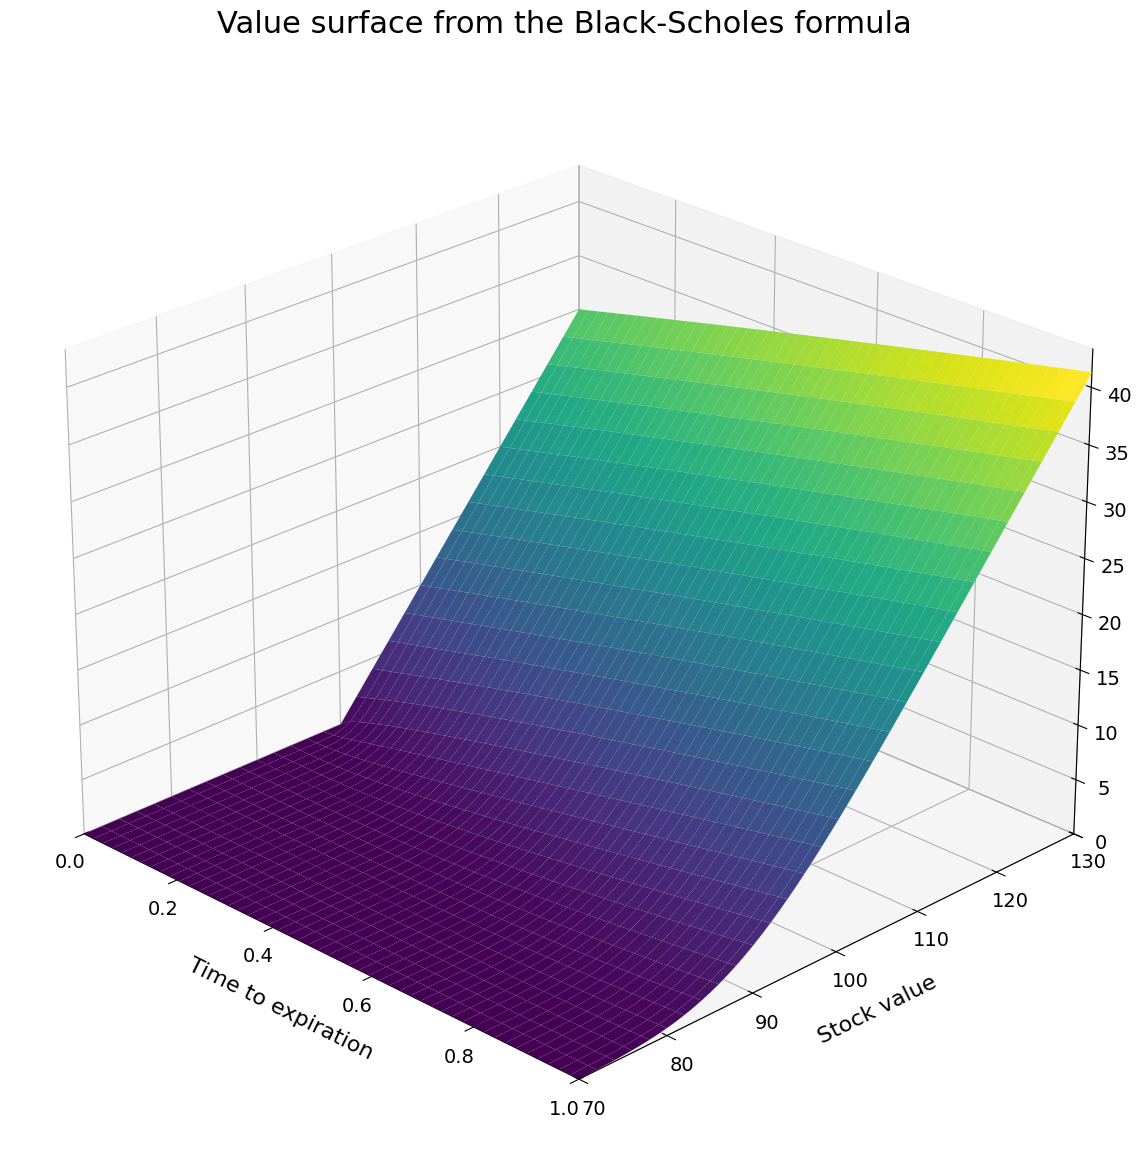

In [7]:
#NBVAL_IGNORE_OUTPUT

from mpl_toolkits.mplot3d import Axes3D

# Trim the padding off smin and smax
trim_data = v.data[:, padding:-padding]

# Our axes
tt = np.linspace(0.0, dt0*(nt-1), nt)
ss = np.linspace(smin+padding, smax-padding, shape[0]-padding*2)

hf = plt.figure(figsize=(12,12))
ha = plt.axes(projection='3d')

# 45 degree viewpoint
ha.view_init(elev=25, azim=-45)

ha.set_xlim3d([0.0,1.0])
ha.set_ylim3d([smin+padding,smax-padding])
ha.set_zlim3d([0,ymax])

ha.set_xlabel('Time to expiration', labelpad=12, fontsize=16)
ha.set_ylabel('Stock value', labelpad=12, fontsize=16)
ha.set_zlabel('Value of call', labelpad=12, fontsize=16)

X, Y = np.meshgrid(tt, ss)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, np.transpose(trim_data), cmap='viridis', edgecolor='none')

hf.suptitle("Value surface from the Black-Scholes formula", fontsize=22)
plt.tight_layout()
plt.show()

Above is the option value plotted as a surface. Lighter colors represent higher value.

## Using the derived formula for Black-Scholes at a point for comparison

Let's take a look at the Black-Scholes derivation which gives us the value of a option at a point.

First some definitions. N(d) is the cumulative distribution function of the standard normal distribution.

$$N(d) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^d e^{-\frac{1}{2}x^2} dx$$

The formula for a call option is (please see the references below for more information):

$$C(S,t) = SN(d_1) - Ke^{-r(T - t)} N(d_2)$$


Where $d_1$ and $d_2$ are the following

$$d_1 = \frac{\ln \left(\frac{S}{K} \right) + \left(r + \frac{\sigma^2}{2} \right)(T - t)}{\sigma \sqrt{T - t}}$$

$$d_2 = d_1 - \sigma \sqrt{T - t} = \frac{\ln \left(\frac{S}{K} \right) + \left(r - \frac{\sigma^2}{2}\right)(T - t)}{\sigma \sqrt{T - t}}$$

This formula is implemented below in the *call_value_bs* function.
We run it on the same problem with 5 time values to compare our results from the formula to our results from solving the PDE with Devito.

devito pde    timesteps:         2000, 0.021815s runtime
call_value_bs timesteps:            5, 2.602303s runtime


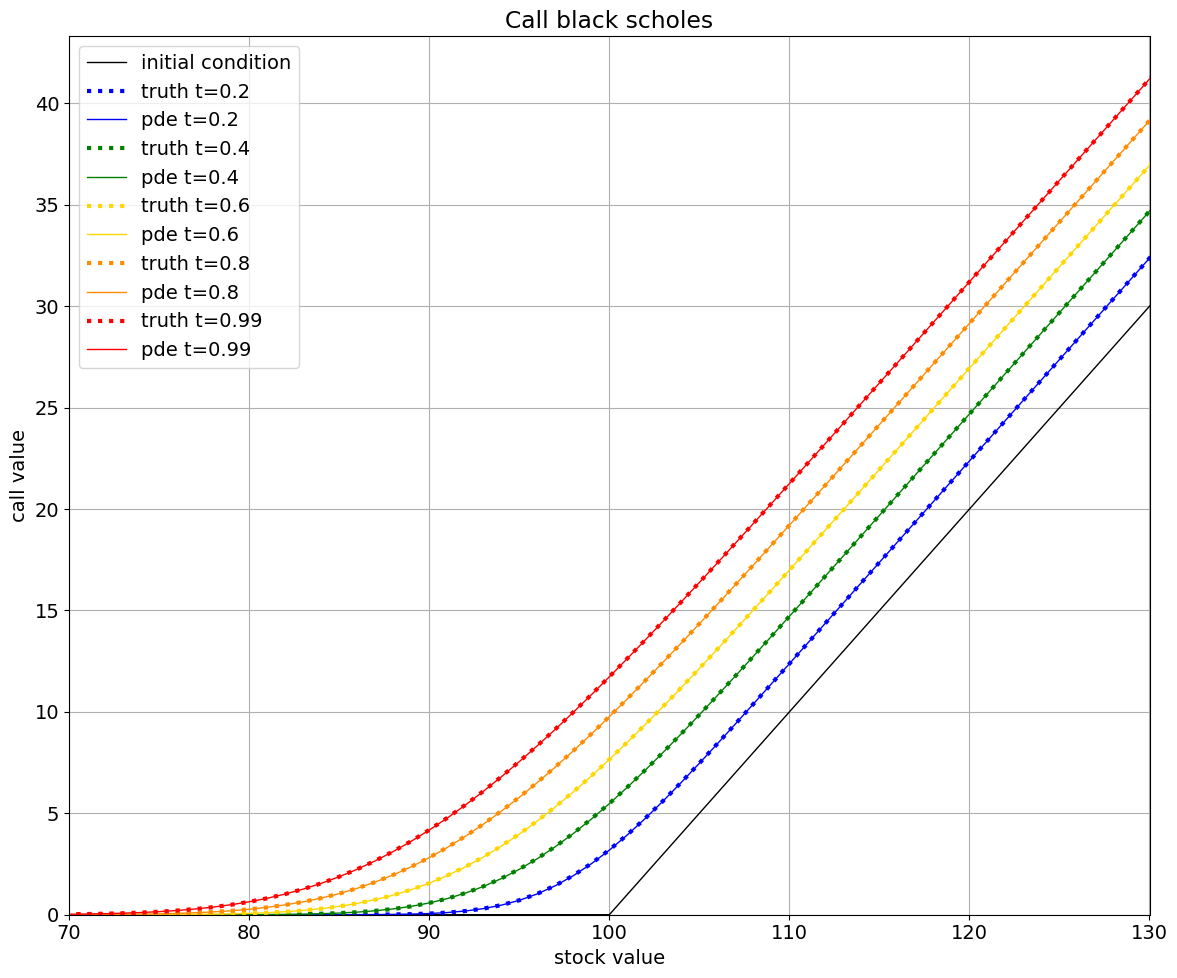

In [8]:
#NBVAL_IGNORE_OUTPUT

# Derived formula for Black Scholes call from 
# https://aaronschlegel.me/black-scholes-formula-python.html
def call_value_bs(S, K, T, r, sigma):
    N = Normal('x', 0.0, 1.0)

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    call = (S * cdf(N)(d1) - K * np.exp(-r * T) * cdf(N)(d2))
    return call

startBF = timer.time()

# Calculate truth and compare to our solution
time = [0.20, 0.40, 0.60, 0.80, 0.99]
results = []

for t_call in time:
    call_price = []
    for x in range(int(smin), int(smax)+1):
        call_price.append(call_value_bs(x, K, t_call, r, sigma).evalf(5))
    results.append(call_price)

endBF = timer.time()

print("devito pde    timesteps: %12.6s, %2.6fs runtime" % (nt-1, endDevito - startDevito))
print("call_value_bs timesteps: %12.6s, %2.6fs runtime" % (len(time), endBF - startBF))

s2 = np.linspace(smin, smax, shape[0])
plt.figure(figsize=(12,10))

colors = ["blue", "green", "gold", "darkorange", "red"]
plt.plot(s2, v.data[0,:], '-', color="black", label='initial condition', linewidth=1)

for i in range(len(time)):
    plt.plot(s2, results[i], ':', color=colors[i], label=f'truth t={time[i]}', linewidth=3)
    plt.plot(s2, v.data[int(time[i]*nt),:], '-', color=colors[i], label=f'pde t={time[i]}', linewidth=1)

plt.xlim([smin+padding,smax-padding])
plt.ylim([0,ymax])

plt.legend()
plt.grid(True)
plt.xlabel("stock value")
plt.ylabel("call value")
plt.title("Call black scholes")
plt.tight_layout()

The graph above shows the results from *call_value_bs* as a dotted line and the results from solving the PDE with devito as a solid line.

Comparing runtime of this function to Devito's runtime is like comparing apples to oranges, but here is a quick comparison anyway. On a machine with a Ryzen 1800x with 8 cores, with 10000 time values ranging from 0.0 to 1.0, Devito takes **0.042 seconds** to run the problem. With 5 time values between 0 and 1, running this function on the same problem takes about 4 seconds. This gives a reasonable idea of Devito's performance in comparison to the alternative solution, i.e. stupid fast.

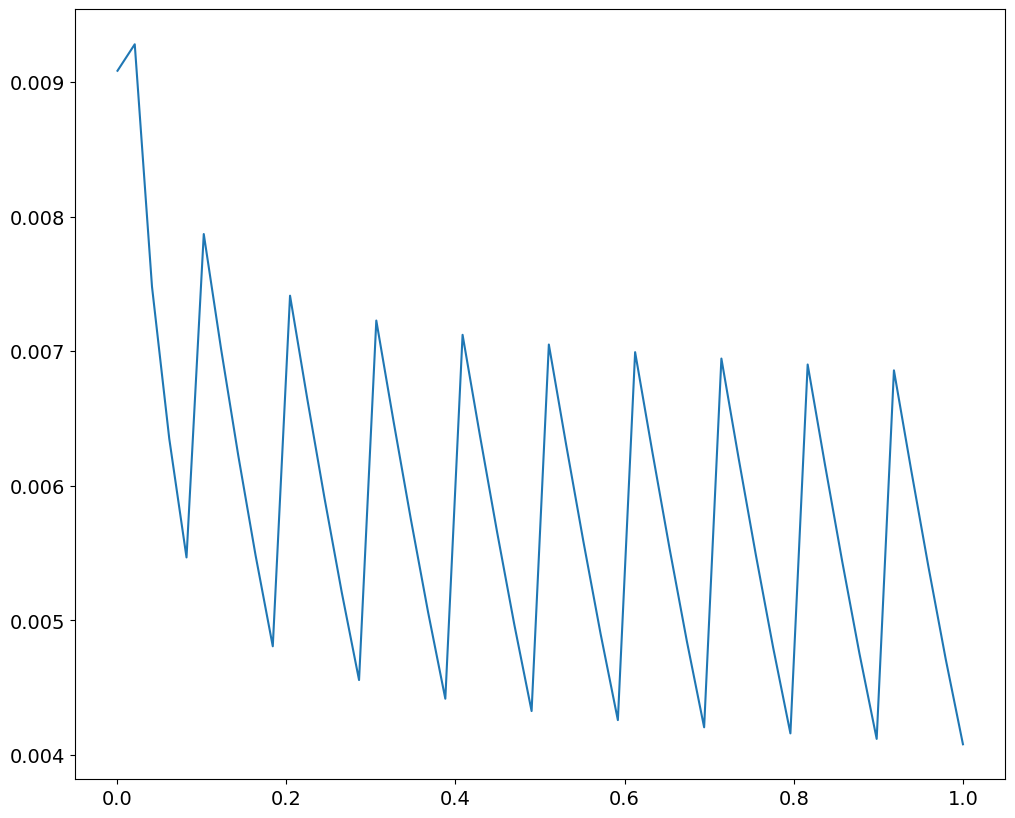

In [9]:
#NBVAL_IGNORE_OUTPUT

# Plot the l2 norm of the formula and our solution over time
t_range = np.linspace(dt0, 1.0, 50)
x_range = range(padding, smax-smin-padding*2, 1)
vals = []

for t in t_range:
    l2 = 0.0
    for x in x_range:
        truth = call_value_bs(x+smin, K, t, r, sigma)
        val   = v.data[int(t*(nt-1)), x]
        l2   += (truth - val)**2

    rms = np.sqrt(np.float64(l2 / len(x_range)))
    vals.append(rms)

plt.figure(figsize=(12,10))
plt.plot(t_range, np.array(vals))



In [10]:
#NBVAL_IGNORE_OUTPUT

mean_rms_error = np.mean(vals)
assert np.isclose(mean_rms_error, 0.005885, rtol=10e-4), f"Mean RMS error is too high: {mean_rms_error}"


Above is a plot of the RMS error of our results from *call_value_bs* and Devito at a time t to expiration, which stays below 0.02 at all time values. The mean RMS error over all time is 0.0073, which is well below a tenth of a percent error.

## References

* http://www.math.unl.edu/~sdunbar1/MathematicalFinance/Lessons/BlackScholes/Solution/solution.pdf
* https://aaronschlegel.me/black-scholes-formula-python.html